# Computation of Radiant Environment Maps using Kato and REPTRAN
This notebook deals with computation of radiant environment maps (REM) for a specific location and time using the Kato and REPTRAN facilities in libRadtran.
Either `ipyparallel` or `dask.distributed` are used for accessing libRadtran computation. A host must be set up for this purpose.

In [1]:
import morticia.rad.librad as librad
import morticia.scene.mortsuba as mit
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
%aimport morticia.scene.mortsuba
import morticia.rad.radute as radute
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pytz
# use latex for font rendering
mpl.rcParams['text.usetex'] = True  # Use TeX to format labels (takes a bit longer)
%matplotlib inline
dask = True  # Set this true if using dask.distributed, false if using ipyparallel

In [2]:
# Select either dask.distributed or ipyparallel
if dask:
    # Import this if using dask.distributed
    from dask.distributed import Client # For contacting the dask scheduler
else:
    # Import this if using ipyparallel
    from ipyparallel import Client  # This is the client class for contacting the hub/controller

In [3]:
# Import required for computing sun azimuth and elevation (altitude)
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_sun

In [4]:
# Set up geographical location and time for REM computation
height_amsl_m = 1400.0  # Altitude of site above mean sea level
pretoria_dpss = EarthLocation(lat=-25.75655*u.deg, lon=28.279648*u.deg, 
                              height=height_amsl_m*u.m)
utcoffset = 2*u.hour  # CAT, Pretoria
timeUTC = Time('2018-4-01 15:00:00') - utcoffset  # Set the time of the event
timeUTCyear_start = Time('2018-01-01 00:00:00') - utcoffset  # Start of year

In [5]:
# Compute location of sun in sky, azimuth and elevation
altazframe = AltAz(obstime=timeUTC, location=pretoria_dpss)
sunaltazs = get_sun(timeUTC).transform_to(altazframe)

In [6]:
print 'Solar Azimuth      : ', sunaltazs.az 
print 'Solar Elevation    :', sunaltazs.alt
sza = 90.0 - sunaltazs.alt.deg
print 'Solar Zenith Angle : ', sza, ' deg.'
day_of_year = int(round(timeUTC.jd - timeUTCyear_start.jd))
print 'Day of Year        :', day_of_year

Solar Azimuth      :  300d22m08.1469s
Solar Elevation    : 38d56m42.1669s
Solar Zenith Angle :  51.054953627  deg.
Day of Year        : 91


In [7]:
# Create a blank libRadtran case
kato = librad.Case(casename='FullKato')

# Choose basic atmospheric profile e.g. tropical
atmos_profile = '../data/atmmod/afglt.dat'
kato.set_option('atmosphere_file', atmos_profile)  # afglt is tropical
kato.set_option('sza', sza)  # Set the solar zenith angle for this day and time
kato.set_option('day_of_year', day_of_year)  # Just sets up seasonal correction
kato.set_option('rte_solver disort')

# Set ground altitude AMSL
kato.set_option('altitude', height_amsl_m/1000.0)  # ground altitude in km above sea level

# Set ground albedo
kato.set_option('albedo 0.5')

# Set up basic King-Byrne aerosol model
kato.set_option('aerosol_default')
# Could use MicroTOPS or Cimel measurements here
aot_wv = np.array([440, 500, 675, 870], dtype=np.float)  # MicroTOPS measurement wavelengths
aot = np.array([0.703, 0.615, 0.362, 0.206])  # MicroTOPS measurements
# Fit King Byrne formula
alpha_0, alpha_1, alpha_2 = librad.king_byrne_formula_fit(aot_wv, aot)
kato.set_option('aerosol_king_byrne', alpha_0, alpha_1, alpha_2)

# For benefit of REM only ...
#kato.set_option('zout', 'boa', '1.0', '5.0')

# Finally, set the Kato option
# Will use kato2 for speed at slightly increased uncertainty
kato.set_option('mol_abs_param', 'kato')
kato.purge = False

In [8]:
# Take a look at the Kato case
kato


atmosphere_file ../data/atmmod/afglt.dat
sza 51.054953627
day_of_year 91
rte_solver disort
altitude 1.4
albedo 0.5
aerosol_default 
aerosol_king_byrne -1.99506671472 -3.0186651281 -1.23381549666
mol_abs_param kato

In [9]:
# Run the case to see what we get
if dask:
    # Run this if using dask.distributed
    # Create a compute client calling the dask Client method with IP 
    # and port of scheduler
    paraclient = Client('146.64.246.94:8786')
    futureRadBatch = paraclient.map(librad.Case.run, [kato])
    # Gather results. This will wait for completion of all tasks.
    kato_run = paraclient.gather(futureRadBatch)    
else:
    # Run this if using ipyparallel
    # Create the ipyparallel client and contact the hub/controller using the profile called icebow and SSH
    # to the machine at the IP address 146.64.246.95
    # This will cause ipyparall to look in ~/.ipython/profile_icebow/security for a file named ipcontroller_client.json.
    # This file is generated by the hub/controller process when started using the ipcluster or ipcontroller command and
    # it may need to be copied from the host running the hub/controller to the machine running the client.
    #

    paraclient = Client(profile='f2', sshserver='dgriffith@f2.csir.co.za', password='mandamoggie')
    # Obtain a "load-balanced" view of the engine cluster
    paraview = paraclient.load_balanced_view()
    # Set the view to blocking mode, which means that we wait for all engines to complete the task before
    # control is returned to the client
    paraview.block = True
    # We will use dill instead of the standard pickle so that we can send instance methods to engines
    paraclient[:].use_dill()
    kato_run = paraview.map(librad.Case.run, [kato])

In [10]:
# Check the return code
# Zero indicates succesful run
kato_run = kato_run[0]
kato_run.run_return_code

0

In [11]:
# Note well the irradiance units for Kato
# This is an integrated band irradiance
kato_run.irrad_units_str()

'W/m^2'

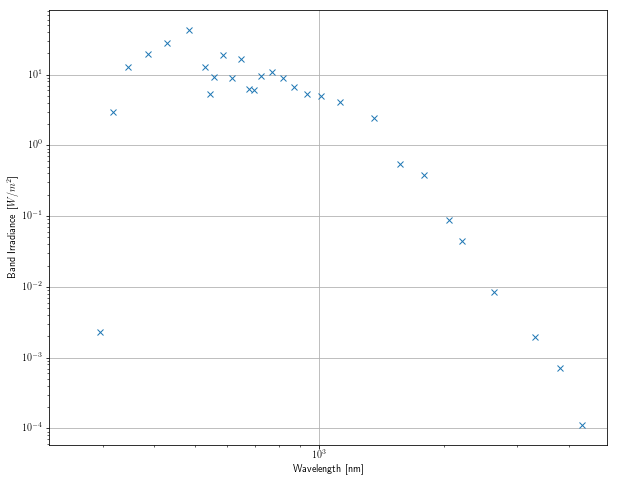

In [12]:
# Plot a graph of the irradiance
plt.figure(figsize=(10,8))
plt.loglog(radute.kato_channels[:,0], kato_run.edn[:].squeeze(), 'x')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Band Irradiance [$' + kato_run.irrad_units_str() + '$]')
plt.grid()

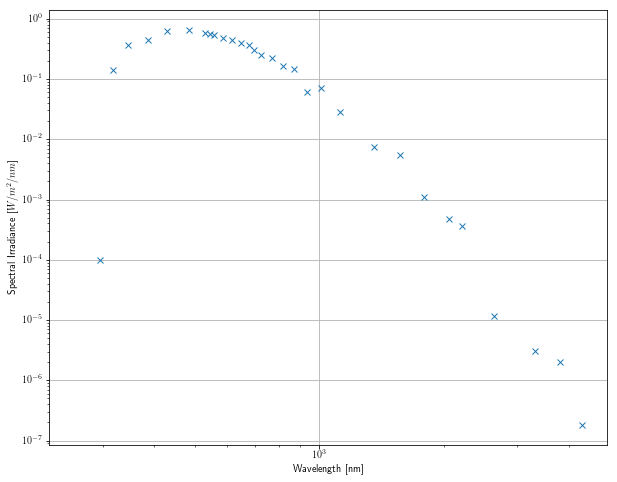

In [13]:
# Calculate and plot the spectral irradiance
kato_channel_widths = radute.kato_channels[:,2] - radute.kato_channels[:,1]
kato_edn_per_nm = kato_run.edn.squeeze() / kato_channel_widths
kato_edir_per_nm = kato_run.edir.squeeze() / kato_channel_widths
kato_eup_per_nm = kato_run.eup.squeeze() / kato_channel_widths
kato_eglo_per_nm = kato_edir_per_nm + kato_edn_per_nm

# Plot a bar graph of the irradiance
plt.figure(figsize=(10,8))
plt.loglog(radute.kato_channels[:,0], kato_edn_per_nm, 'x')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Spectral Irradiance [$' + kato_run.irrad_units_str() + '/nm$]')
plt.grid()

In [14]:
# Now create a REPTRAN run with similar conditions
# Create a blank libRadtran case
rep = librad.Case(casename='Reptran')

# Choose basic atmospheric profile e.g. tropical
atmos_profile = '../data/atmmod/afglt.dat'
rep.set_option('atmosphere_file', atmos_profile)  # afglt is tropical
rep.set_option('sza', sza)  # Set the solar zenith angle for this day and time
rep.set_option('day_of_year', day_of_year)  # Just sets up seasonal correction
rep.set_option('rte_solver disort')

# Set ground altitude AMSL
rep.set_option('altitude', height_amsl_m/1000.0)  # ground altitude in km above sea level

# Set ground albedo
rep.set_option('albedo 0.5')

# Set up basic King-Byrne aerosol model
rep.set_option('aerosol_default')
# Use same aerosol as before
rep.set_option('aerosol_king_byrne', alpha_0, alpha_1, alpha_2)

# Select solar TOA file
# solar_toa_file = '../data/solar_flux/Solar_irradiance_Thuillier_2002.txt'
# solar_toa_file = '../data/solar_flux/atlas_plus_modtran'
solar_toa_file = 'solar_flux/kurudz_1.0nm.dat'

# Set wavelength range
wv_minimum_range = [[radute.kato_channels.min(), -2.0], 
                    [radute.kato_channels.max(), +2.0]]
wv_range = librad.lookup_nearest_in_file('radata/' + solar_toa_file, 
                                         wv_minimum_range)  # lookup in local copy
# Set wavelength limits as for full Kato if possible
rep.set_option('wavelength', 250.0, wv_range[1])

rep.set_option('source solar', '../data/' + solar_toa_file)
rep.set_option('mol_abs_param', 'reptran', 'coarse')

#rep.set_option('verbose')
#rep.purge = False

In [15]:
rep

atmosphere_file ../data/atmmod/afglt.dat
sza 51.054953627
day_of_year 91
rte_solver disort
altitude 1.4
albedo 0.5
aerosol_default 
aerosol_king_byrne -1.99506671472 -3.0186651281 -1.23381549666
wavelength 250.0 4608.0
source solar ../data/solar_flux/kurudz_1.0nm.dat
mol_abs_param reptran coarse

In [16]:
# Run the case to see what we get
if dask:
    # Run this if using dask.distributed
    # Create a compute client calling the dask Client method with IP 
    # and port of scheduler
    paraclient = Client('146.64.246.94:8786')
    futureRadBatch = paraclient.map(librad.Case.run, [rep])
    # Gather results. This will wait for completion of all tasks.
    rep_run = paraclient.gather(futureRadBatch)    
else:
    # Run this if using ipyparallel
    # Create the ipyparallel client and contact the hub/controller using the profile called icebow and SSH
    # to the machine at the IP address 146.64.246.95
    # This will cause ipyparallel to look in ~/.ipython/profile_icebow/security for a file named ipcontroller_client.json.
    # This file is generated by the hub/controller process when started using the ipcluster or ipcontroller command and
    # it may need to be copied from the host running the hub/controller to the machine running the client.
    #

    paraclient = Client(profile='f2', sshserver='dgriffith@f2.csir.co.za', password='mandamoggie')
    # Obtain a "load-balanced" view of the engine cluster
    paraview = paraclient.load_balanced_view()
    # Set the view to blocking mode, which means that we wait for all engines to complete the task before
    # control is returned to the client
    paraview.block = True
    # We will use dill instead of the standard pickle so that we can send instance methods to engines
    paraclient[:].use_dill()
    rep_run = paraview.map(librad.Case.run, [rep])

In [17]:
# Check the run return code, zero is good, anything else is not
rep_run = rep_run[0]
rep_run.run_return_code

0

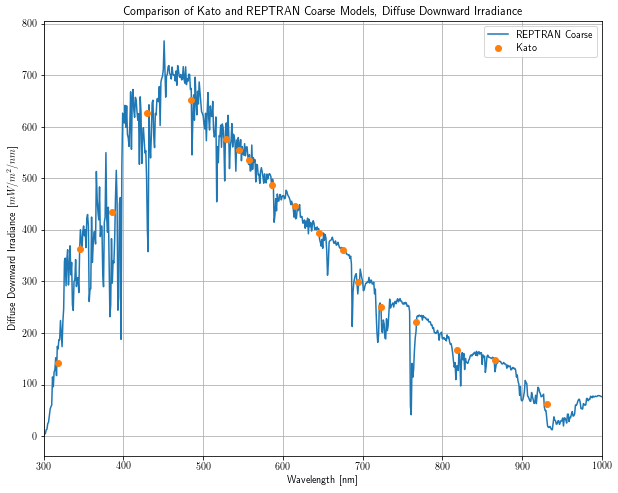

In [18]:
# Plot the edn for the coarse REPTRAN model, with Kato
# Plot a graph of the irradiance
plt.figure(figsize=(10,8))
# Kato outputs in W, but REPTRAN in this case is mW, multiply Kato by 1000.0
plt.plot(rep_run.wvl, rep_run.edn.squeeze(), 
        radute.kato_channels[:,0], kato_edn_per_nm * 1000.0, 'o')
plt.title('Comparison of Kato and REPTRAN Coarse Models, Diffuse Downward Irradiance')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Diffuse Downward Irradiance [$' + rep_run.irrad_units_str() + '$]')
plt.xlim([300.0, 1000.0])
plt.legend(['REPTRAN Coarse', 'Kato'])
plt.grid()


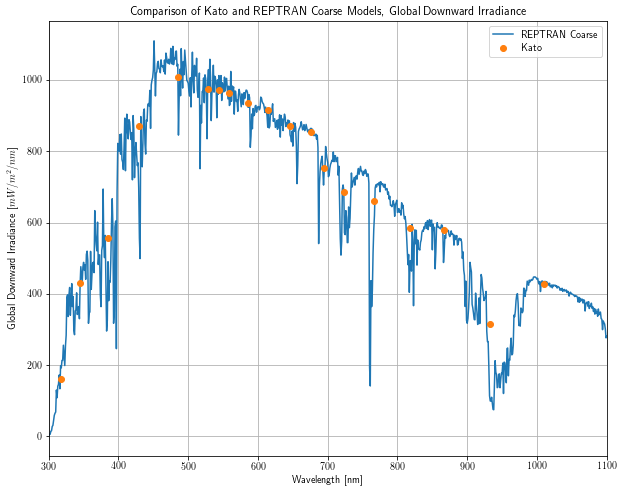

In [19]:
# Plot the global (edn + edir) for the coarse REPTRAN model, with Kato
# Plot a graph of the irradiance
plt.figure(figsize=(10,8))
# Kato outputs in W, but REPTRAN in this case is mW, multiply Kato by 1000.0
plt.plot(rep_run.wvl, rep_run.edn.squeeze() + rep_run.edir.squeeze(), 
        radute.kato_channels[:,0], kato_eglo_per_nm * 1000.0, 'o')
plt.title('Comparison of Kato and REPTRAN Coarse Models, Global Downward Irradiance')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Global Downward Irradiance [$' + rep_run.irrad_units_str() + '$]')
plt.xlim([300.0, 1100.0])
plt.legend(['REPTRAN Coarse', 'Kato'])
plt.grid()

In [20]:
# Now generate a REM based on the Kato case
kato_rem = librad.RadEnv(base_case=kato, n_pol=256, n_azi=128, hemi=True, n_sza=70)

In [21]:
%time kato_rem.run_dask_parallel(dask_client=paraclient, purge=True)

Wall time: 1min 23s


D:\Projects\GitHub\MORTICIA\morticia\rad\librad.py:2333: RuntimeWarning: divide by zero encountered in log
  self.xd_opt_depth = -np.log(self.xd_trans_toa)  # Compute the optical depths from a level to TOA


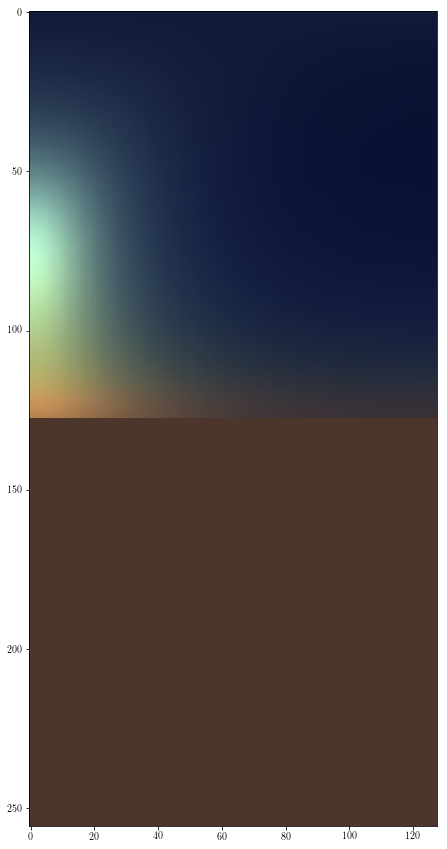

In [22]:
# Plot the REM using a selection of 3 bands as a colour image
bandchoice = [19, 12 , 4]
izout = 0
plt.figure(figsize=(10, 15))
plt.imshow(kato_rem.xd_uu[:,:,bandchoice,izout,0]/kato_rem.xd_uu[:,:,bandchoice,izout,0].max())

In [23]:
# Compute path radiances and transmittances
kato_rem.compute_path_transmittance()
kato_rem.compute_path_radiance()

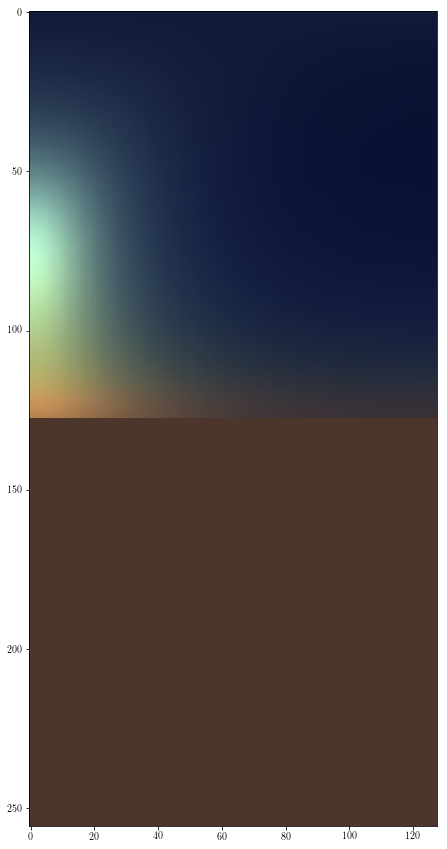

In [24]:
# Plot the path radiances using a selection of 3 bands as a colour image
bandchoice = [19, 12 , 4]
izout = 0
plt.figure(figsize=(10, 15))
plt.imshow(kato_rem.xd_path_radiance[:,:,bandchoice,izout,0]/
           kato_rem.xd_path_radiance[:,:,bandchoice,izout,0].max())

In [30]:
# Write the REM to an OpenEXR file
kato_rem.write_openexr('kato_full', chan_names=['B', 'G', 'R'], chan_per_exr=3, 
                       normalise=False, repeat_azi=1, use_mitsuba_wvl=False)